In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import os
import glob
import warnings
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import sys
basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

warnings.filterwarnings('ignore')


## Build Composite library

In [15]:
from utils.library.composite_library import fill_group_info, collect_library, decompose_library
from utils.library.extra_functions import *
        
libraries = [
    ('m_ij', 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP', 'tensor_library', 'tensor_SVDPipeline_PMG_CF.pkl'),
    ('v', 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP', 'tensor_library', None), #Not focused on flow dynamics
    ('c', 'Public/WT/ECad-GFP', 'scalar_library', None), #Not focused on cadherin dynamics, just include it as a source
]

    
extra_functions = [
    lambda data: material_derivative_terms(data, keys=['m_ij']),
    #lambda data: tensor_to_scalar(data, ['E', 'm_ij']),
    lambda data: active_strain_decomposition(data, key='m_ij'),
    lambda data: add_static_sources(data, couple='m_ij'),
    #lambda data: add_dorsal_source(data, couple='m_ij', key='ELLIPSE_A=0.5_B=0.25'),
    lambda data: symmetric_tensor_couple(data, ['m_ij', 'E_active', 'E_passive', 'E_full']),
    lambda data: remove_terms(data, max_space_order=1),
    lambda data: multiply_tensor_by_scalar(data, None, ['c']),
]


with h5py.File(os.path.join(libraries[0][1], 'derivative_library.h5'), 'r') as h5f:
    embryoIDs = list(h5f.keys())

with h5py.File('Public/myosin_dynamics_fitting.h5', 'w') as data:
    with tqdm(total=len(embryoIDs)) as pbar:
        pbar.set_description('Collecting embryo data')
        for embryoID in embryoIDs:
            pbar.set_postfix(embryoID=embryoID)
            group, feature_names = fill_group_info(data, embryoID, libraries)
            collect_library(group, 
                            libraries, 
                            feature_names, 
                            extra_functions=extra_functions)
            decompose_library(group, libraries, window_length=9)
            
            pbar.update()

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

## Learn Myosin model

  0%|          | 0/13 [00:00<?, ?it/s]

D_t m_ij = 0.053 Static_DV Tr(m_ij) + -0.038 c Static_DV Tr(m_ij) + 0.077 c m_ij + 0.284 c m_ij Tr(E_full) + -0.519 c m_ij Tr(m_ij) + -0.086 m_ij + 0.516 m_ij Tr(E_full) + 0.699 m_ij Tr(m_ij)
PCA Component R2=-5.29245	MSE=0.572259


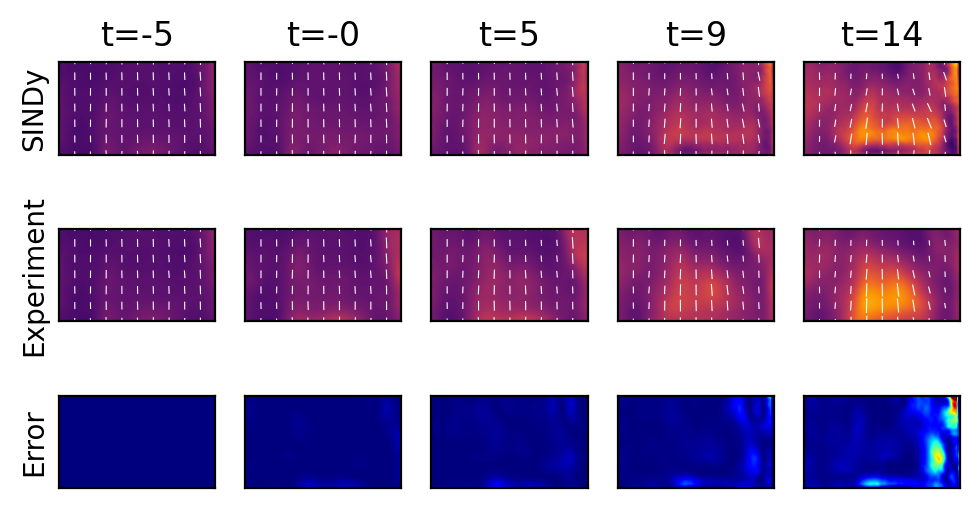

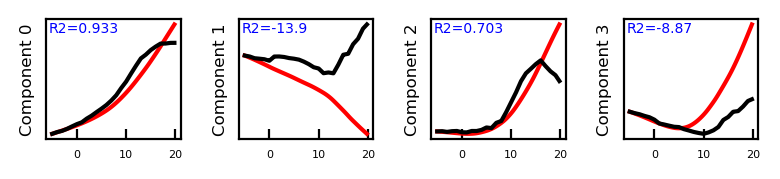

In [17]:
import pickle as pk
from utils.modeling.sindy_utils import *
from utils.modeling.evaluate_utils import *

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams['figure.dpi'] = 200
np.set_printoptions(precision=3, suppress=True)


path = 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP'
key = 'm_ij'

model = pk.load(open(os.path.join(path, 'decomposition_models', 'tensor_SVDPipeline_PMG_CF.pkl'), 'rb'))

evr = model['svd'].explained_variance_ratio_
keep=np.cumsum(evr) <= 0.95
scaled_evr = evr / np.min(evr[keep]) * keep

info = dict(
    key=key,
    tmin=-5, tmax=10,
    threshold=1e-2,
    alpha=1e1,
    n_candidates_to_drop=0,
    n_models=10,
    subset_fraction=0.1,
    overleaf_only=False,
    component_weight=scaled_evr,
    collect_function=collect_raw_data,
)

with h5py.File('Public/myosin_dynamics_fitting.h5', 'r') as h5f:
    sindy = fit_sindy_model(h5f, **info)

    #Evaluate model
    data = h5f['ensemble']
    tmin, tmax = -5, 20    
    tmin = max(tmin, int(np.min(data['fields'][key].attrs['t'])))
    tmax = min(tmax, int(np.max(data['fields'][key].attrs['t'])))
    pred, interp, times = sindy_predict(data, key, sindy, tmin=tmin, tmax=tmax)
    sindy_predictions_plot(pred, interp, times)
    decomposed_predictions_plot(pred, interp, times, model, keep)
